In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from glob import glob


In [ ]:
# Problem Overview
'''
This project is a  Kaggle Monet GAN project.
Goal: Learn GANs by transforming photos into Monet-style images.
'''


'\nThis project is a light version of the Kaggle Monet GAN project.\nGoal: Learn GANs by transforming photos into Monet-style images.\n'

In [3]:
# Load and preprocess data (64x64, reduced sample)
def load_images(image_paths, size=(64, 64)):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=size)
        img = img_to_array(img)
        img = (img / 127.5) - 1
        images.append(img)
    return np.array(images)

photo_paths = glob('photo_jpg/*.jpg')[:200]
monet_paths = glob('monet_jpg/*.jpg')[:200]

photos = load_images(photo_paths)
monets = load_images(monet_paths)

print("Photo shape:", photos.shape)
print("Monet shape:", monets.shape)


Photo shape: (200, 64, 64, 3)
Monet shape: (200, 64, 64, 3)


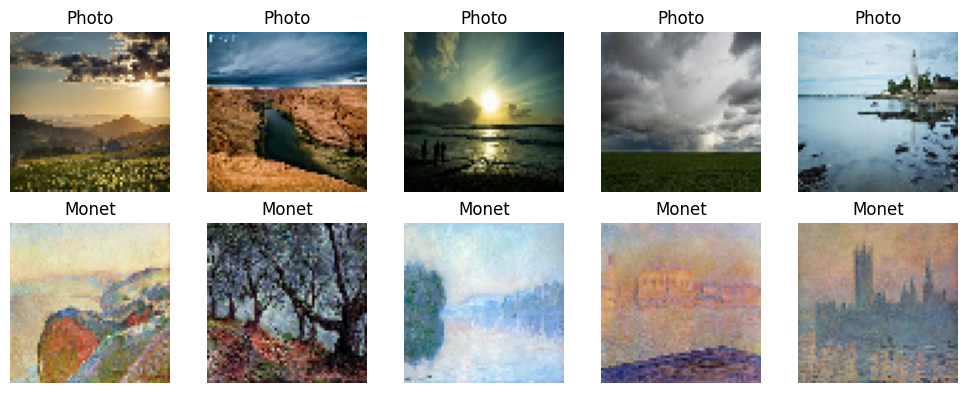

In [4]:
# Visualize few samples
plt.figure(figsize=(10, 4))
num_samples = min(5, len(photos), len(monets))
for i in range(num_samples):
    plt.subplot(2, num_samples, i+1)
    plt.imshow(np.clip((photos[i] + 1) / 2, 0, 1))
    plt.axis('off')
    plt.title("Photo")
    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.imshow(np.clip((monets[i] + 1) / 2, 0, 1))
    plt.axis('off')
    plt.title("Monet")
plt.tight_layout()
plt.show()


In [5]:
# Generator Model (64x64 input)
def build_generator():
    inputs = layers.Input(shape=(64, 64, 3))
    x = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh')(x)
    return Model(inputs, x, name="Generator")

gen = build_generator()
gen.summary()


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 3)      │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,547 (1.02 MB)

 Trainable params: 268,547 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Discriminator Model (64x64 input)
def build_discriminator():
    inputs = layers.Input(shape=(64, 64, 3))
    x = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    return Model(inputs, x, name="Discriminator")

disc = build_discriminator()
disc.summary()


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,105 (652.75 KB)

 Trainable params: 167,105 (652.75 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile and loss setup
gen_optimizer = Adam(2e-4, beta_1=0.5)
disc_optimizer = Adam(2e-4, beta_1=0.5)
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [8]:
# Training step
@tf.function
def train_step(real_photo, real_monet):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = gen(real_photo, training=True)
        real_output = disc(real_monet, training=True)
        fake_output = disc(fake_monet, training=True)

        gen_loss = bce_loss(tf.ones_like(fake_output), fake_output)
        disc_loss = bce_loss(tf.ones_like(real_output), real_output) + \
                    bce_loss(tf.zeros_like(fake_output), fake_output)

    gen_grad = tape.gradient(gen_loss, gen.trainable_variables)
    disc_grad = tape.gradient(disc_loss, disc.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grad, gen.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grad, disc.trainable_variables))
    return gen_loss, disc_loss


In [9]:
# Train (1 epoch, batch size 8)
EPOCHS = 1
BATCH_SIZE = 8

for epoch in range(EPOCHS):
    for i in range(0, len(photos), BATCH_SIZE):
        photo_batch = photos[i:i + BATCH_SIZE]
        monet_batch = monets[i:i + BATCH_SIZE]
        g_loss, d_loss = train_step(photo_batch, monet_batch)
    print(f"Epoch {epoch+1}: Gen Loss={g_loss.numpy():.4f}, Disc Loss={d_loss.numpy():.4f}")


Epoch 1: Gen Loss=0.7216, Disc Loss=0.7714


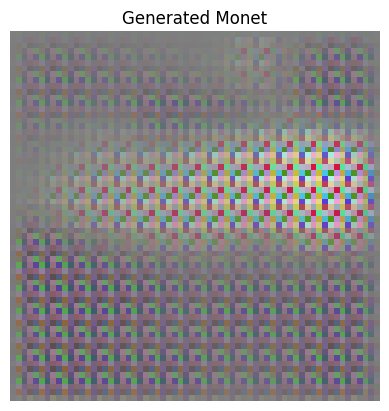

In [10]:
# Generate and display result
sample = np.expand_dims(photos[0], axis=0)
fake = gen(sample, training=False).numpy()[0]

plt.imshow(np.clip((fake + 1) / 2, 0, 1))
plt.title("Generated Monet")
plt.axis('off')
plt.show()


In [12]:
# Conclusion
'''

Future upgrades:
- Full CycleGAN
- Longer training
- Higher resolution images

Great job getting started!
'''


'\n\nFuture upgrades:\n- Full CycleGAN\n- Longer training\n- Higher resolution images\n\nGreat job getting started!\n'